# Lending Club

## Pipeline

- Exploratory Analyses
    - Number of Opened Loans with Respect to Years and Status
    - Number of Opened Loans with Respect to Years and Status (%)
    - Reorganization of target classes
- Data Cleaning
    - Identification of date,categoric and continues columns.
    - Null treatment
    --- Outlier detection
    - Analyses, cleaning and selection of categoric features
    - Analyses, cleaning and selection of continues features
- Data Configuration
    - Transformation (Box-cox) 
    - Standardization-Normalization
- Model Development
    - Oversampling - class_weight setting
    - Correlation check and feature elimination
    - Feature selection
    - Multinomial Logistic Regression
    - Randomsearch

### Exploratory Analyses

Number of disbursed loans increased in recent periods. Moreover, some loan types are only observable in certain periods of time.
For example, recent periods have Late (16-30 days), Late (31-120 days) loans status codes and prior periods have 'Does not meet the credit policy. Status:Fully Paid' 
and 'Does not meet the credit policy. Status:Charged Off' status codes. Best practice could be splitting these loans in 2 parts; goods and bad loans. 
However, it is expected to classify according to loan_status so we will use all status codes.

We are facing with a highly unbalanced data. We have 9 different classes and most of them occupy a small percentage of data.
Moreover, most of these classes are similar. For example late(16-30) and late(31-120) are similar status types. 
So, I decided to merge them end decrease number of classes and increase number of rows in each class.
Also Defaulted loans will be charged off in coming periods so I will also merge them.

### Data Cleaning

#### Identification of date,categoric and continues columns.

We are going to use Logistic regression for this classification problem. And we need to understand our data structure. 
After examination of all columns, it is necessary to split our features in to different groups.
Unique keys are empty, so we will drop them.
Date columns are structured as objects so we need to change their data settings to date format, In case of usage of them is necessary.
Another issue is using categoric features. In logistic regression, it is not possible to use categoric features directly. 
So, we will implement encoding operations on these columns.

#### Null treatment

After dropping the columns that have high null ratios, our number of columns decrease to 104 from 145.

#### Analyses, cleaning and selection of categoric features

Most of the categoric variables are binary, for those who are not;
    like zip_code, emp_title and title there are several ways to implement encoding, but I am planning to remove them from data.
The most critical part of these categoric features are addr_state and purpose because it is not possible to encode them with a hierarchical order and one hot encoding creates lots of new columns.
So, I decided to drop them. But, I am planning to group adrr_state column according to region.

#### Transformation(box-cox)

With respect to assumptions of Logistic regression,  it is not necessary to implement a transformation in logistic regression. 
However, we will also use this data in other questions and to assure OLS assumptions like linearity, homoscedasticity and 
normally distrubuted residuals, it is necessary to implement transformation to continues features

### Correlation Check

This section checks correlation between all features and drops one of the correlated features if abs of correlation coefficient is greater than 0.70

# Q1
Predict time until loan is paid in full, charged off, or defaults

As you mentioned, I spent not too much time for this question.
Step by step;

 - Rearrange date columns.
 - Take the difference between issue date and last payment date to find length of payment period.
 - Drop unrelated loan status codes
 - Split as train and test.
 - Implement feature selection with RFE step by step
 - Implement OLS 
 - Calculate MSE 
 
In step 5 and 6, I changed maximum number of features step by step;
Started with all features: R2 Adj  0.640 and MSE 61
Final model with 6 features: R2 Adj  0.602 and MSE 1

# Q2
Classify the loans with respect to loan_status column. Hence, obviously you need a
train/test split (use 80-20 split).

After all data cleaning and feature corrections;

I set my target and implement a feature selection with Lasso regression and SelectFromModel methods.
After selecting 15 most significantly related features, I implemented multinomial logistic regression.

Parameters of this regression are ;

class_weight : To deal with imbalanced data. I also tried SMOTE for oversampling but this method produced better results.

multi_class : To deal with Multinomial target structure

solver : 'lbfgs', default solver can not handle multiclass labels so there was 3 options. After gridsearch, this produced best results.

After I implemented logistic regression, I acquired an accuracy of 0.872.
Other metrics are available belove including precision, recall, f1 and roc_auc scores and curves.
It is obvious that for smaller class labels our precision score is not high enough. That means treatment of imbalance is not effective. But with a grid search and treatment imbalance it would be better.

# Q3
Compare the difference between loan_amnt column and funded_amnt_inv column.
Basically, what I am asking is predict which applications will be underapproved by the
investors and by how much?

This question needs assumptions to make.

First thing to decide is description of underapproval. 

The assumption is %1 negative difference between loan amount and funded amount means underapproval.

After that I implement feature selection and create a model to find expected funded_amnt_inv and plot actual and pred values with loan amount.
After correcting %1 difference loan amount and funded amount, I calculated confusion matrix for underapproved loans and main stats like accuracy, precision, etc.

R2 Adj of model is: 0.998
    
Accuracy is: 0.9683
    
So I found both which credits will be underapproved and how much they will be.
It is obvious that for smaller class labels our precision score is not high enough. That means treatment of imbalance is not effective. But with a grid search and treatment imbalance it would be better.

## Codes & Details

In [1]:
from IPython.display import HTML, display

import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import pandas as pd
df = pd.read_csv('loan.csv', encoding='latin-1')

### Exploratory Analyses

In [2]:
df2 = df[['issue_d', 'loan_status']]
df2['year'] = pd.DatetimeIndex(df2['issue_d']).year

df3 = df2.groupby(by = ['year', 'loan_status']).count()
df3.reset_index(inplace = True)
pivot_df = df3.pivot(index='year', columns='loan_status', values='issue_d').fillna(0)

index_order = ['Current', 'Fully Paid', 'Does not meet the credit policy. Status:Fully Paid', 
               'Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period', 'Default','Charged Off', 
               'Does not meet the credit policy. Status:Charged Off']


Number of Opened Loans with Respect to Years and Status

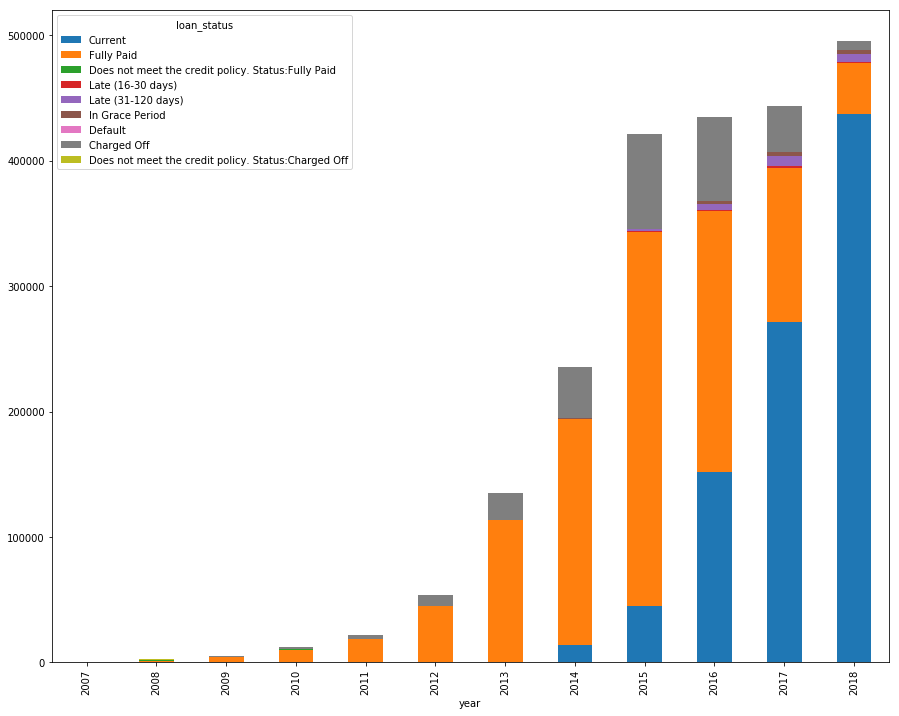

In [3]:
pivot_df.loc[:,index_order].plot.bar(stacked=True, figsize=(15,12))

Number of Opened Loans with Respect to Years and Status (%)

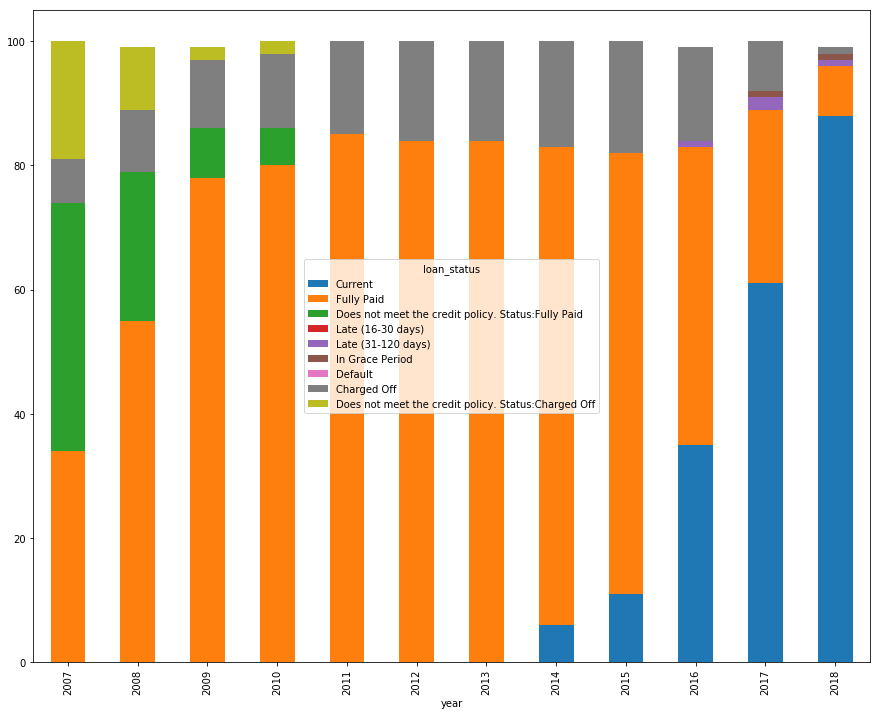

In [4]:
pivot_df2 = pivot_df.copy()
for i in pivot_df.index:
    pivot_df2.loc[i,:] = round(pivot_df2.loc[i,:]*100/pivot_df.loc[i,:].sum())

pivot_df2.loc[:,index_order].plot.bar(stacked=True, figsize=(15,12))

We are facing with a highly unbalanced data. We have 9 different classes and most of them occupy a small percentage of data.
Moreover, most of these classes are similar. For example late(16-30) and late(31-120) are similar status types. 
So, I decided to merge them end decrease number of classes and increase number of rows in each class.
Also Defaulted loans will be charged off in coming periods so I will also merge them.

#### Reorganize

In [5]:
#Reorganize target classes for a more convenient result
df['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [6]:
a = ['Late (31-120 days)','Late (16-30 days)', 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off', 'Charged Off', 'Default' ]
b = ['Late', 'Late', 'Fully Paid', 'Default-Charged Off','Default-Charged Off','Default-Charged Off' ]

df['loan_status'].replace(a,b, inplace = True)

#Number of loans in each class
df[['loan_amnt', 'loan_status']].groupby('loan_status').count()

,loan_amnt
loan_status,
Current,919695
Default-Charged Off,262447
Fully Paid,1043940
In Grace Period,8952
Late,25634


In [61]:
#Create a sample
sample = df

### Data Cleaning

#### Identification of date,categoric and continues columns.

In [62]:
columns_drop = ['id','member_id']

columns_date = ['earliest_cr_line',
                'issue_d',
                'last_credit_pull_d',
                'last_pymnt_d',
                'next_pymnt_d',
                'pymnt_plan',
                'hardship_start_date',
                'hardship_end_date',
                'payment_plan_start_date',
                'debt_settlement_flag_date',
                'settlement_date']

columns_categoric  =  ['addr_state',
                        'application_type',
                        'desc',
                        'term',
                        'emp_title',
                        'emp_length',
                        'home_ownership',
                        'initial_list_status',
                        'loan_status',
                        'purpose',
                        'grade',
                        'sub_grade',
                        'title',
                        'url',
                        'verification_status_joint',
                        'verification_status',
                        'zip_code',
                        'sec_app_earliest_cr_line',  
                        'hardship_flag',
                        'hardship_type',
                        'hardship_reason',
                        'hardship_status',
                        'hardship_loan_status',
                        'disbursement_method',
                        'debt_settlement_flag',
                        'settlement_status',
                        'num_tl_120dpd_2m',
                        'num_tl_30dpd',
                        'policy_code']

#### Null treatment

In [63]:
#Definening, splitting and dropping related columns in to new dfs
sample_dates = sample[columns_date]
sample_cat = sample[columns_categoric]
sample_cont = sample.drop(columns_drop+columns_date+columns_categoric, axis  = 1)
term = sample_cat['term'].str.extract('(\d+)').astype(int)
# Print null conditions of each columns in percentages
#print (sample_dates.isnull().mean() * 100)
#print (sample_cat.isnull().mean() * 100)
#print (sample_cont.isnull().mean() * 100)

#Dropping the columns with null ratios more than %70.
sample_dates.dropna(axis=1, thresh=int(0.30*len(sample_dates)), inplace = True)
sample_cat.dropna(axis=1, thresh=int(0.30*len(sample_cat)),inplace = True)
sample_cont.dropna(axis=1, thresh=int(0.30*len(sample_cont)), inplace = True)

#Fill all null values with zero. after I check over continues features, I decided to fill nulls with 0 
sample_cont.fillna(0.1, inplace = True)

#### Analyses, cleaning and selection of categoric features

In [64]:
#Drop unnecessary columns
cat_values_drop1 = ['emp_title', 'title', 'zip_code', 'addr_state', 'purpose' ]
sample_cat.drop(cat_values_drop1, axis = 1, inplace = True)

#null % of cat features
print(sample_cat.isnull().mean() * 100)

application_type        0.000000
term                    0.000000
emp_length              6.498389
home_ownership          0.000000
initial_list_status     0.000000
loan_status             0.000000
grade                   0.000000
sub_grade               0.000000
verification_status     0.000000
hardship_flag           0.000000
disbursement_method     0.000000
debt_settlement_flag    0.000000
num_tl_120dpd_2m        6.796973
num_tl_30dpd            3.108639
policy_code             0.000000
dtype: float64


In [65]:
#I use 2 different labeling methods in this categorical encoding.
#binary encoding and label encoding. I split those 2 different type of columns.
cat_dummys = ['application_type', 'term', 'home_ownership', 'initial_list_status','verification_status', 'hardship_flag', 'disbursement_method','debt_settlement_flag']
cat_label_encoder = ['emp_length', 'grade', 'sub_grade','num_tl_120dpd_2m', 'num_tl_30dpd' ]


#I cleaned data for proper use of label encoding
sample_cat['emp_length'].fillna('-1 years', inplace = True)
sample_cat['emp_length'].replace(['< 1 year','10+ years'],['0 year','10 years'], inplace=True)
sample_cat[['num_tl_120dpd_2m', 'num_tl_30dpd']] = sample_cat[['num_tl_120dpd_2m', 'num_tl_30dpd']].fillna(4)


#I implemented ordinal encoding by using Label encoder because ordinal encoder is not available in my business notebook.
for i in range(0,len(cat_label_encoder)):
    le = LabelEncoder()
    le.fit(sample_cat[cat_label_encoder[i]])
    sample_cat[cat_label_encoder[i]] = le.transform(sample_cat[cat_label_encoder[i]])
    
    
#After ordinal encoding, I implemented binary encoding and created different flags.
new_dummy_flags = pd.get_dummies(sample_cat[cat_dummys], drop_first=True)

#Merge encoded categorical columns
sample_cat.drop(cat_dummys, axis=1, inplace = True)
sample_cat = pd.merge(sample_cat, new_dummy_flags, left_index=True, right_index=True )

#### Analyses, cleaning and selection of continues features

In [66]:
sample_cont.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,...,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06
mean,1.504693e+04,1.504166e+04,1.502344e+04,1.309291e+01,4.458076e+02,7.799229e+04,1.881002e+01,3.068765e-01,5.768291e-01,1.689132e+01,...,8.346807e-02,2.015305e+00,9.118556e+01,4.102352e+01,1.281765e-01,4.677356e-02,1.727018e+05,4.989377e+04,2.268048e+04,4.237255e+04
std,9.190245e+03,9.188413e+03,9.192332e+03,4.832114e+00,2.671737e+02,1.126961e+05,1.418731e+01,8.672251e-01,8.859590e-01,2.302605e+01,...,4.858500e-01,1.834397e+00,1.859837e+01,3.640940e+01,3.645036e-01,3.775252e-01,1.813875e+05,4.992334e+04,2.300499e+04,4.501137e+04
min,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+03,8.000000e+03,8.000000e+03,9.490000e+00,2.516500e+02,4.600000e+04,1.188000e+01,0.000000e+00,0.000000e+00,1.000000e-01,...,0.000000e+00,1.000000e+00,9.030000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.697775e+04,1.979700e+04,7.800000e+03,1.309500e+04
50%,1.290000e+04,1.287500e+04,1.280000e+04,1.262000e+01,3.779900e+02,6.500000e+04,1.783000e+01,0.000000e+00,0.000000e+00,1.000000e-01,...,0.000000e+00,2.000000e+00,9.770000e+01,3.330000e+01,0.000000e+00,0.000000e+00,1.075730e+05,3.700100e+04,1.590000e+04,3.144600e+04
75%,2.000000e+04,2.000000e+04,2.000000e+04,1.599000e+01,5.933200e+02,9.300000e+04,2.448000e+01,0.000000e+00,1.000000e+00,3.000000e+01,...,0.000000e+00,3.000000e+00,1.000000e+02,6.670000e+01,0.000000e+00,0.000000e+00,2.522000e+05,6.347100e+04,2.990000e+04,5.760200e+04
max,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,3.300000e+01,2.260000e+02,...,5.800000e+01,3.200000e+01,1.000000e+02,1.000000e+02,1.200000e+01,8.500000e+01,9.999999e+06,3.408095e+06,1.569000e+06,2.118996e+06


#### Transformation(box-cox)

With respect to assumptions of Logistic regression,  it is not necessary to implement a transformation in logistic regression. 
However, we will also use this data in other questions and to assure OLS assumptions like linearity, homoscedasticity and 
normally distrubuted residuals, it is necessary to implement transformation to continues features

In [67]:
sample_cont.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,...,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06
mean,1.504693e+04,1.504166e+04,1.502344e+04,1.309291e+01,4.458076e+02,7.799229e+04,1.881002e+01,3.068765e-01,5.768291e-01,1.689132e+01,...,8.346807e-02,2.015305e+00,9.118556e+01,4.102352e+01,1.281765e-01,4.677356e-02,1.727018e+05,4.989377e+04,2.268048e+04,4.237255e+04
std,9.190245e+03,9.188413e+03,9.192332e+03,4.832114e+00,2.671737e+02,1.126961e+05,1.418731e+01,8.672251e-01,8.859590e-01,2.302605e+01,...,4.858500e-01,1.834397e+00,1.859837e+01,3.640940e+01,3.645036e-01,3.775252e-01,1.813875e+05,4.992334e+04,2.300499e+04,4.501137e+04
min,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+03,8.000000e+03,8.000000e+03,9.490000e+00,2.516500e+02,4.600000e+04,1.188000e+01,0.000000e+00,0.000000e+00,1.000000e-01,...,0.000000e+00,1.000000e+00,9.030000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.697775e+04,1.979700e+04,7.800000e+03,1.309500e+04
50%,1.290000e+04,1.287500e+04,1.280000e+04,1.262000e+01,3.779900e+02,6.500000e+04,1.783000e+01,0.000000e+00,0.000000e+00,1.000000e-01,...,0.000000e+00,2.000000e+00,9.770000e+01,3.330000e+01,0.000000e+00,0.000000e+00,1.075730e+05,3.700100e+04,1.590000e+04,3.144600e+04
75%,2.000000e+04,2.000000e+04,2.000000e+04,1.599000e+01,5.933200e+02,9.300000e+04,2.448000e+01,0.000000e+00,1.000000e+00,3.000000e+01,...,0.000000e+00,3.000000e+00,1.000000e+02,6.670000e+01,0.000000e+00,0.000000e+00,2.522000e+05,6.347100e+04,2.990000e+04,5.760200e+04
max,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,3.300000e+01,2.260000e+02,...,5.800000e+01,3.200000e+01,1.000000e+02,1.000000e+02,1.200000e+01,8.500000e+01,9.999999e+06,3.408095e+06,1.569000e+06,2.118996e+06


In [68]:
import scipy.special as sc


sample_cont_11 = sample_cont.replace(0, 0.1)

sample_cont_11[sample_cont_11<=0] = 0.1
#box-cox transformation
for i in list(sample_cont_11.columns):
    sample_cont_11[i] = stats.boxcox(sample_cont_11[i])[0]

### Normalization-Standardization

In [69]:
#We imlemented z transformation to all of our columns. (Normalization)
sample_cont_normalized=(sample_cont_11-sample_cont_11.mean())/sample_cont_11.std()
sample_cont_normalized.round(10)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,-1.907386,-1.907332,-1.889096,0.249109,-1.942248,-0.356184,0.114595,-0.478743,1.155861,-0.957751,...,-0.233972,0.734120,0.661501,-1.436216,2.704349,-0.171553,-0.513532,-0.702690,0.847847,-0.158380
1,1.442838,1.443418,1.446272,1.188226,1.210682,0.500614,0.833358,-0.478743,-0.794667,1.293918,...,-0.233972,1.652805,0.146731,-1.436216,2.704349,-0.171553,1.183906,1.158008,-0.078132,1.062086
2,-1.244906,-1.244536,-1.236498,1.037112,-1.095730,-0.231239,-0.767558,-0.478743,-0.794667,-0.957751,...,-0.233972,-1.550275,0.661501,-1.436216,-0.369769,-0.171553,0.133647,-0.962676,-0.151399,-0.469265
3,-1.476030,-1.475755,-1.464679,1.188226,-1.350682,0.540874,-0.035707,-0.478743,-0.794667,-0.957751,...,-0.233972,0.734120,0.661501,1.123185,-0.369769,-0.171553,1.223797,-0.041038,-0.894665,0.439696
4,1.442838,1.443418,1.446272,0.732330,1.093743,-0.289570,0.820086,-0.478743,-0.794667,-0.957751,...,-0.233972,1.388456,-0.115458,-1.436216,-0.369769,-0.171553,0.261606,-0.229891,-0.471247,0.203142
5,-1.130431,-1.130021,-1.123298,0.531166,-1.015823,1.517647,1.628458,-0.478743,1.498044,-0.957751,...,-0.233972,1.087730,0.661501,0.709899,-0.369769,-0.171553,2.298439,2.133173,1.638139,1.878630
6,-2.088532,-2.088589,-2.066704,1.037112,-2.099037,-0.480179,-2.367887,-0.478743,1.155861,-0.957751,...,-0.233972,0.294162,0.661501,-1.436216,-0.369769,-0.171553,-2.131807,-2.119684,-2.644949,-1.994313
7,-1.042131,-1.041691,-1.035902,0.249109,-0.941922,-0.075043,1.101697,-0.478743,-0.794667,-0.957751,...,-0.233972,-1.550275,0.661501,0.991664,-0.369769,-0.171553,-0.001516,1.042983,0.731749,0.689885
8,-1.244906,-1.244536,-1.236498,1.037112,-1.095730,-0.399353,0.387069,-0.478743,1.155861,1.076333,...,-0.233972,1.652805,-1.258438,0.709899,-0.369769,-0.171553,-0.544946,0.108341,0.263268,0.250313
9,-1.042131,-1.041691,-1.035902,0.427731,-0.925067,2.991637,0.034401,2.081139,1.155861,0.894064,...,-0.233972,0.294162,0.661501,0.161763,-0.369769,-0.171553,1.497818,1.247085,2.270965,1.016566


### Correlation Check

This section checks correlation between all features and drops one of the correlated features if abs of correlation coefficient is greater than 0.70

In [70]:
# Create correlation matrix
corr_matrix = sample_cont_normalized.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# Drop features 
sample_cont_normalized.drop(sample_cont_normalized[to_drop[1:]], axis=1, inplace = True)

### Final Data

In [71]:
sample_final = pd.merge(sample_cont_normalized,sample_cat, left_index = True, right_index = True) 

# Q1
Predict time until loan is paid in full, charged off, or defaults

#### Target Setting

In [72]:
sample_dates_1 = sample_dates[['issue_d','last_pymnt_d']]
sample_dates_1['issue_d'] = pd.to_datetime(sample_dates_1.issue_d)
sample_dates_1['last_pymnt_d'] = pd.to_datetime(sample_dates_1.last_pymnt_d)

sample_dates_1[['issue_d','last_pymnt_d']].head()
payment_time_length = round(((sample_dates_1['last_pymnt_d'] - sample_dates_1['issue_d']).dt.days)/365*12,0)


sample_final_1 = sample_final.copy()
sample_final_1['term'] = term
sample_final_1['payment_time_length'] = payment_time_length
sample_final_1 = sample_final_1[(sample_final_1['loan_status'] != 'Late') &
               (sample_final_1['loan_status'] != 'In Grace Period') & 
               (sample_final_1['loan_status'] != 'Current')]

target = sample_final_1['payment_time_length'].fillna(0)

sample_final_1.drop(['payment_time_length','loan_status'], axis = 1, inplace = True)

x_train, x_test, y_train, y_test = train_test_split(sample_final_1.values, target, test_size = 0.2, random_state = 42)

#### Feature Selection

In [80]:
feature_idx = selector.support_
#selected_feature_name = sample_final_1.columns[feature_idx]

sample_final_2 = sample_final_1 #[selected_feature_name]
x_train, x_test, y_train, y_test = train_test_split(sample_final_2.values, target.values, test_size = 0.2, random_state = 42)

In [81]:
selected_feature_name

Index(['loan_amnt', 'total_rev_hi_lim', 'tot_hi_cred_lim',
       'total_bal_ex_mort'],
      dtype='object')

#### Model

In [82]:
train_c = sm.add_constant(x_train) 

lm = sm.OLS(y_train,train_c).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                 2.608e+04
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        01:01:49   Log-Likelihood:            -3.6287e+06
No. Observations:             1045109   AIC:                         7.258e+06
Df Residuals:                 1045044   BIC:                         7.258e+06
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6862      0.291      9.217      0.0

In [85]:
test_c = x_test
test_c = sm.add_constant(test_c)
y_pred4 = lm.predict(test_c)
print('MSE : ')
print(round(metrics.mean_squared_error(y_test, y_pred4),0))

MSE : 
61.0


# Q2
Classify the loans with respect to loan_status column. Hence, obviously you need a
train/test split (use 80-20 split).

#### Target Setting

In [86]:
#target setting
target = sample_final['loan_status']
#Encoding of 
le = LabelEncoder()
le.fit(target)
target_1 = le.transform(target)

#Indipendent variables
features = sample_final.drop('loan_status', axis =1)

#### Feature Selection

In [87]:
x_train, x_test, y_train, y_test = train_test_split(features.values, target.values, test_size = 0.2, random_state = 42)

In [88]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV()

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.01)
sfm.fit(x_train, le.transform(y_train))
n_features = sfm.transform(x_train).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 15:
    sfm.threshold += 0.01
    X_transform = sfm.transform(x_train)
    n_features = X_transform.shape[1]


In [89]:
#Setting all selected features, limiting data with this features and splitting data again.
feature_idx = sfm.get_support()
selected_feature_name = features.columns[feature_idx]

features_1 = features[selected_feature_name]
x_train, x_test, y_train, y_test = train_test_split(features_1.values, target.values, test_size = 0.2, random_state = 42)

#### Logistic Regression

In [90]:
#To plot Roc curve of each class in multiclass logistic regression
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

Accuracy Score:

0.8638213449994913

Confusion Matrix:

[[130147     11   1195  27149  25400]
 [     0  50691   1880     74      8]
 [     0   1146 207161    296      0]
 [   770      3     19    515    518]
 [  1982     17     18   1085   2049]]

Summary table:

                     precision    recall  f1-score   support

            Current       0.98      0.71      0.82    183902
Default-Charged Off       0.98      0.96      0.97     52653
         Fully Paid       0.99      0.99      0.99    208603
    In Grace Period       0.02      0.28      0.03      1825
               Late       0.07      0.40      0.12      5151

        avg / total       0.97      0.86      0.91    452134


Roc-Curve:



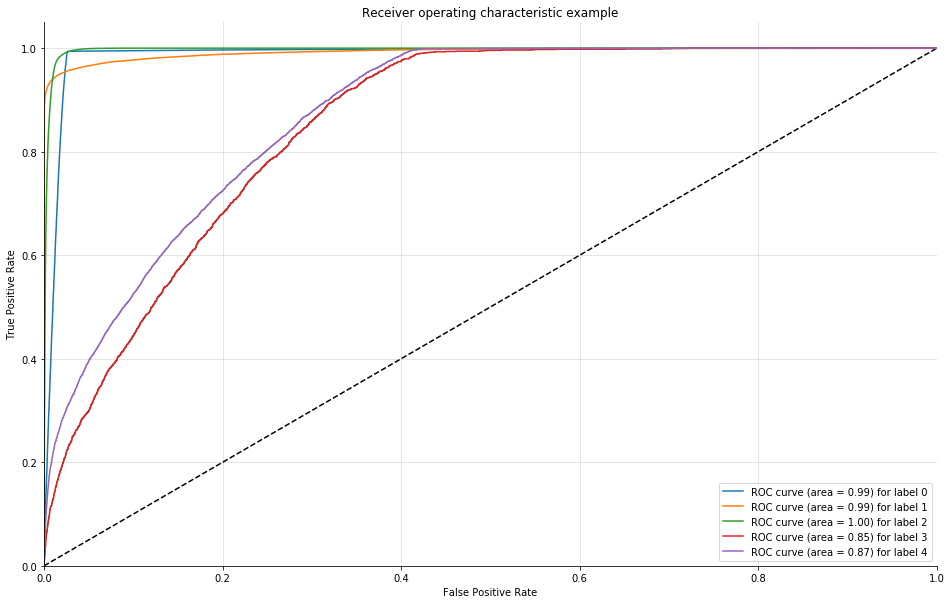

In [91]:
logreg = LogisticRegression(class_weight = 'balanced', multi_class = 'multinomial', solver  = 'lbfgs')
model = logreg.fit(x_train, y_train)
prediction=logreg.predict(x_test)

cm = confusion_matrix(y_test, prediction)

print('Accuracy Score:\n')
print(accuracy_score(y_test, prediction))
print('\nConfusion Matrix:\n')
print(cm)

from sklearn.metrics import classification_report
print('\nSummary table:\n')
print(classification_report(y_test, prediction))

print('\nRoc-Curve:\n')
plot_multiclass_roc(logreg, x_test, y_test, n_classes=5, figsize=(16, 10))

In [92]:
#Coefficients of all multinomial equations for  each class
pd.DataFrame(model.coef_, columns = features_1.columns).transpose()

,0,1,2,3,4
loan_amnt,0.133167,2.607443,-3.398154,0.322944,0.334600
int_rate,-0.339169,-0.228845,0.326616,0.133949,0.107449
out_prncp,3.030785,-5.071858,-4.188630,2.844650,3.385054
total_pymnt,0.009989,-3.843225,3.605579,0.239669,-0.012012
total_rec_late_fee,-0.190934,-0.046909,-0.394978,0.286266,0.346555
recoveries,-0.975654,3.683952,-0.636043,-1.021535,-1.050721
last_pymnt_amnt,0.122872,-0.136958,0.620209,-0.243668,-0.362455
open_act_il,0.324252,-0.509868,-0.456265,0.351950,0.289931
sub_grade,0.020451,0.008656,-0.126528,0.037843,0.059579
application_type_Joint App,0.091200,-0.161865,-0.134777,0.197141,0.008302


# Q3
Compare the difference between loan_amnt column and funded_amnt_inv column.
Basically, what I am asking is predict which applications will be underapproved by the
investors and by how much?

In [93]:
#Merge continues and categoric features
sample_final = pd.merge(sample_cont,sample_cat, left_index = True, right_index = True) 

#target setting
target = sample_final['funded_amnt_inv']
#
sample_final.drop(['loan_status','funded_amnt', 'funded_amnt_inv'], axis=1, inplace = True)

#Lets split our main data
x_train, x_test, y_train, y_test = train_test_split(sample_final.values, target.values, test_size = 0.2, random_state = 42)



#### Feature Selection

In [94]:
# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV(tol = 0.000001)

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf)
sfm.fit(x_train, y_train)
n_features = sfm.transform(x_train).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 15:
    sfm.threshold += 0.00001
    X_transform = sfm.transform(x_train)
    n_features = X_transform.shape[1]

In [102]:
feature_idx = sfm.get_support()
selected_feature_name = sample_final.columns[feature_idx]

sample_final_1 = sample_final#[selected_feature_name]
x_train, x_test, y_train, y_test = train_test_split(sample_final_1.values, target.values, test_size = 0.2, random_state = 42)

#### Model

In [103]:
train_c = sm.add_constant(x_train) 
lm = sm.OLS(y_train,train_c).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.852e+07
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        01:09:45   Log-Likelihood:            -1.2468e+07
No. Observations:             1808534   AIC:                         2.494e+07
Df Residuals:                 1808439   BIC:                         2.494e+07
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9711      0.000   6495.064      0.0

In [104]:
test_c = x_test
test_c = sm.add_constant(test_c)
y_pred4 = lm.predict(test_c)
print('MSE : ')
print(round(metrics.mean_squared_error(y_test, y_pred4),0))

MSE : 
54499.0


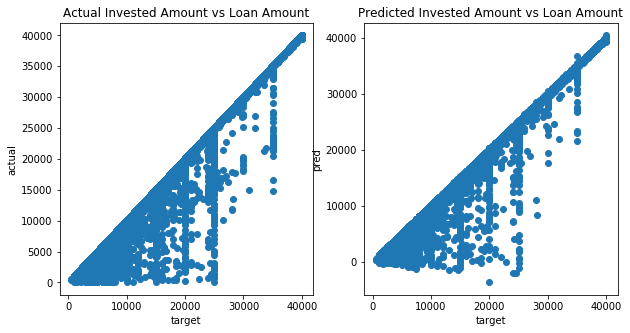

In [105]:
plt.subplots(1,2,figsize=(10,5))
x = x_test.transpose()[0]
y = y_test

plt.subplot(1,2,1)
plt.scatter(x, y)
plt.title('Actual Invested Amount vs Loan Amount')
plt.xlabel("target")
plt.ylabel("actual")

x = x_test.transpose()[0]
y = y_pred4
plt.subplot(1,2,2)
plt.title('Predicted Invested Amount vs Loan Amount')
plt.xlabel("target")
plt.ylabel("pred")

plt.scatter(x, y)

plt.show()

In [107]:
#creating a summary dataframe for each loan record.
comparison_df = pd.DataFrame(data = {'loan_amnt': (x_test.transpose()[0]), 'funded_amnt' : (y_test),'funded_amnt_pred' : (y_pred4), 'actual_diff' : (x_test.transpose()[0] - y_test), 'pred_diff' : (x_test.transpose()[0] - y_pred4)})
comparison_df.round(0)

#Defining the description of underapproved loans
comparison_df['pred_diff_cleaned'] = np.where( abs(comparison_df['pred_diff']) < comparison_df['funded_amnt']*0.01,0, comparison_df['pred_diff'] )
comparison_df['actual_diff_cleaned'] = np.where( abs(comparison_df['actual_diff']) < comparison_df['funded_amnt']*0.01,0, comparison_df['actual_diff'] )

#Creating binary code for underapproved and exactly approved loans
comparison_df['actual_underapproved_f'] = np.where(comparison_df['actual_diff_cleaned'] <= 0, 0, 1)
comparison_df['pred_underapproved_f'] = np.where(comparison_df['pred_diff_cleaned'] <= 0, 0, 1)

#Confusion matrix and summary statistics 
from sklearn.metrics import confusion_matrix
print(confusion_matrix(comparison_df['actual_underapproved_f'], comparison_df['pred_underapproved_f']))

tn, fp, fn, tp = confusion_matrix(comparison_df['actual_underapproved_f'], comparison_df['pred_underapproved_f']).ravel()
print('\nAccuracy: '+str((tp+tn)/(tn+fp+fn+tp))+'\n')

print(classification_report(comparison_df['actual_underapproved_f'], comparison_df['pred_underapproved_f']))

[[425613  18446]
 [   651   7424]]

Accuracy: 0.9577625217302835

             precision    recall  f1-score   support

          0       1.00      0.96      0.98    444059
          1       0.29      0.92      0.44      8075

avg / total       0.99      0.96      0.97    452134

